## Brain tumor Classification - Xception


### Step№1: Import libraries

In [5]:

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from keras.applications import VGG16, Xception
from tensorflow.keras.layers import (Input, 
                                     Add, 
                                     Dense, 
                                     Activation, 
                                     BatchNormalization, 
                                     Flatten, 
                                     Conv2D, 
                                     AveragePooling2D, 
                                     MaxPooling2D, 
                                     GlobalAveragePooling2D,
                                     Dropout)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.callbacks import (ReduceLROnPlateau, 
                                        EarlyStopping, 
                                        ModelCheckpoint, 
                                        LearningRateScheduler)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [6]:
# Visualizing plot of train and validation loss &  accuracy
def plot_history_acc_loss(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    
    sns.despine()
    ax[0].plot(epochs, train_acc, color= 'red',
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, color= 'green',
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, color='red',
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, color='green',
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

### Step№2: Importing dataset

In [7]:
Brain_directory = ('../archive/Training/')
test_directory = ('../archive/Testing/')

In [8]:
classes = os.listdir(Brain_directory)
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [9]:
for idx, name in enumerate(classes):
    print(f"{idx} = {name}", end=", ")

0 = glioma_tumor, 1 = meningioma_tumor, 2 = no_tumor, 3 = pituitary_tumor, 

### Step№3 Data Augmentation

In [10]:
#resize images and convert to numpy.
IMAGE = []
LABELS = []
image_size = 299
for label in classes:
    path_train = os.path.join(Brain_directory, label)
    for j in os.listdir(path_train):
        img = cv2.imread(os.path.join(path_train, j))
        img = cv2.resize(img,(image_size,image_size))
        IMAGE.append(img)
        LABELS.append(label)
            
        
for label in classes:
    path_test = os.path.join(test_directory, label)
    for j in os.listdir(path_test):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        IMAGE.append(img)
        LABELS.append(label)
        
X = np.array(IMAGE)
y = np.array(LABELS)

In [11]:
classes_info = {}
classes = sorted(os.listdir(Brain_directory))
for name in classes:
    classes_info[name] = len(os.listdir(Brain_directory + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title= 'Training dataset')
fig.update_layout({'title':{"x":0.1}})
fig.show()


{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


In the training dataset:

    3 = pituitary_tumor 827(28.8%). 
    0 = glioma_tumor 826(28.8%), 
    1 = meningioma_tumor 822(28.6%), 
    2 = no_tumor 395(13.8%).

In [12]:
classes_info = {}
classes = sorted(os.listdir(test_directory))
for name in classes:
    classes_info[name] = len(os.listdir(test_directory + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='Testing dataset')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}


In the testing dataset:

    1 = meningioma_tumor 115(29.2%), 
    2 = no_tumor 105(26.6%),
    0 = glioma_tumor 100(25.4%), 
    3 = pituitary_tumor 74(18.8%)

### Split dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((2611, 299, 299, 3), (653, 299, 299, 3))

### to_categorical

In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### Step№4 Data Generator

In [15]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [16]:
train_generator = image_generator.flow_from_directory(
    batch_size = 40,
    directory = Brain_directory,
    shuffle = True, 
    target_size = (299, 299),
    class_mode = 'categorical',
    subset = 'training'
)

Found 2297 images belonging to 4 classes.


In [17]:
validation_generator = image_generator.flow_from_directory(
    batch_size = 40, 
    directory = Brain_directory,
    shuffle = True, 
    target_size = (299, 299),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 573 images belonging to 4 classes.


In [18]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(
    batch_size = 4, 
    directory = test_directory, 
    shuffle = True, 
    target_size = (299, 299), 
    class_mode = 'categorical'
)

Found 394 images belonging to 4 classes.


In [19]:
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [20]:
train_images, train_labels = next(train_generator)
train_images.shape

(40, 299, 299, 3)

### Step№5 Showing images

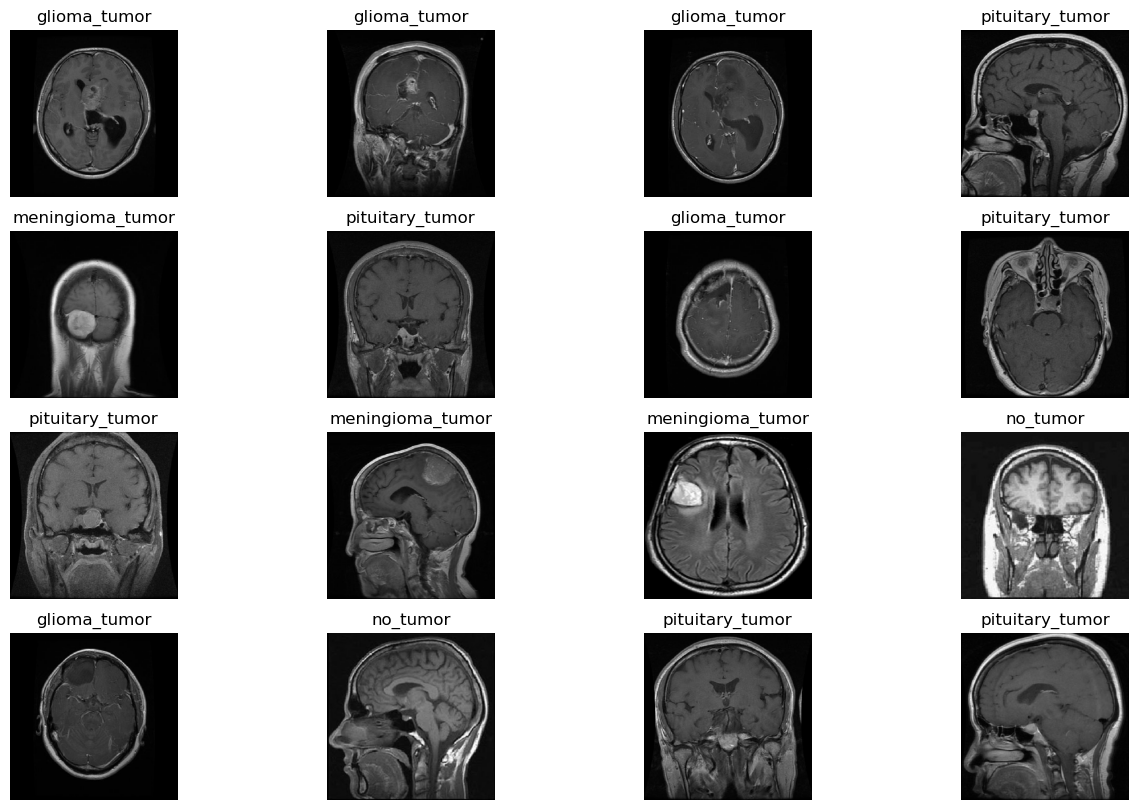

In [21]:
L = 4 
W = 4

fig, axes = plt.subplots(L, W, figsize = (15, 10))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(classes[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

### I. Step№6 Transfer learning - Xception
![jcs-07-00169-g006.png](attachment:jcs-07-00169-g006.png)


    Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions. 
    The data first goes through the entry flow, then through the middle flow which is repeated eight times, and finally through the exit flow.  Convolution and Separable Convolution layers are followed by batch normalization

In [22]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath= 'brainweights.hdf5', verbose = 1, save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 2, mode = 'auto', min_lr = 1e-15)
                             

In [23]:
basemodel = Xception(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (299, 299, 3)))

In [24]:
basemodel.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [25]:
for layer in basemodel.layers[:-20]:
    layer.trainable = False

In [26]:
train_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory = Brain_directory,
    shuffle = True, 
    target_size = (299, 299),
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = image_generator.flow_from_directory(
    batch_size = 4, 
    directory = Brain_directory,
    shuffle = True, 
    target_size = (299, 299),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [27]:
y_test

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

### Step№7 Train model

### One dense layer

In [28]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(512, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


model_1 = Model(inputs = basemodel.input, outputs = headmodel) 

In [29]:
model_1.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [30]:
history = model_1.fit(X_train, y_train,
    epochs = 50, 
    validation_data = (X_test, y_test), 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.9260 - accuracy: 0.6208
Epoch 1: val_loss improved from inf to 3.31664, saving model to brainweights.hdf5
82/82 [==============================] - 19s 135ms/step - loss: 0.9260 - accuracy: 0.6208 - val_loss: 3.3166 - val_accuracy: 0.4043
Epoch 2/50
82/82 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.7805
Epoch 2: val_loss improved from 3.31664 to 0.88049, saving model to brainweights.hdf5
82/82 [==============================] - 10s 126ms/step - loss: 0.5750 - accuracy: 0.7805 - val_loss: 0.8805 - val_accuracy: 0.6769
Epoch 3/50
82/82 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8579
Epoch 3: val_loss did not improve from 0.88049
82/82 [==============================] - 10s 120ms/step - loss: 0.3996 - accuracy: 0.8579 - val_loss: 1.9206 - val_accuracy: 0.5283
Epoch 4/50
82/82 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8863
Epoch 4: val_

C:\Users\User\AppData\Local\Temp\ipykernel_9892\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



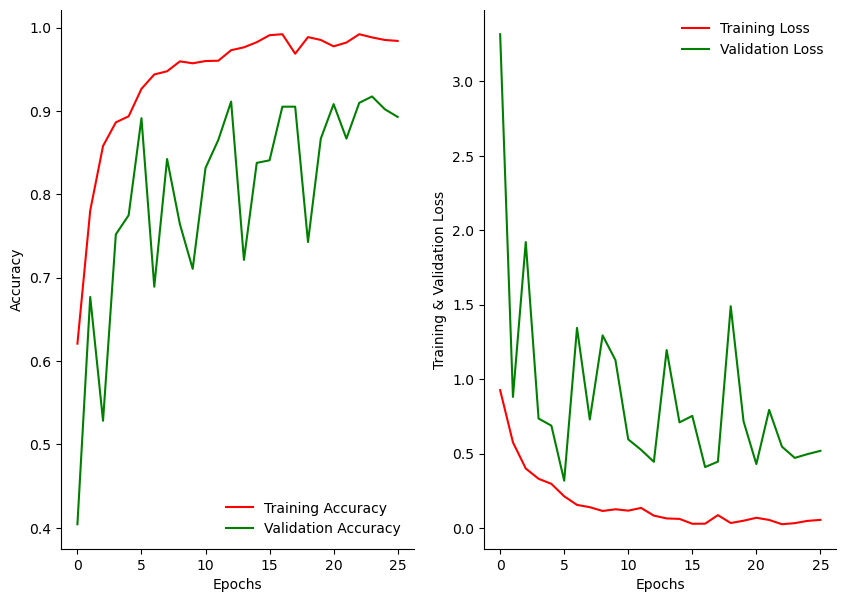

In [31]:
plot_history_acc_loss(history)

### Step№8 Evaluate Model with Test Samples, classification_report, confusion_matrix

In [32]:
evaluate = model_1.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 2s 76ms/step - loss: 0.5181 - accuracy: 0.8928
Testing accuracy : 0.8928024768829346
Testing loss: 0.5181455016136169


In [33]:
test_predictions = model_1.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 85ms/step
              precision    recall  f1-score   support

           0       0.97      0.78      0.87       181
           1       0.86      0.90      0.88       200
           2       0.72      0.99      0.83        95
           3       0.99      0.95      0.97       177

    accuracy                           0.89       653
   macro avg       0.89      0.90      0.89       653
weighted avg       0.91      0.89      0.89       653



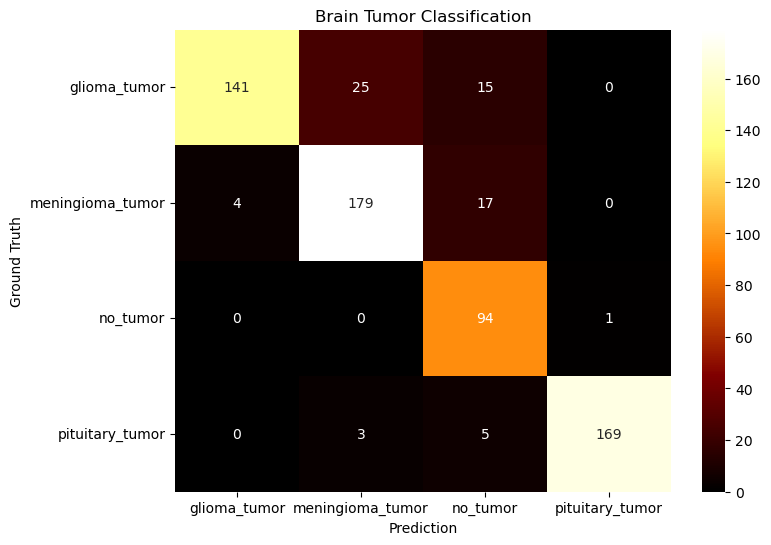

In [34]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cnf, cmap='afmhot', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    With one hidden layer, the model predicts stably, but overtraining is observed.
    no_tumor - 72% precision.

### Step№9 Visualizing Model Predictions

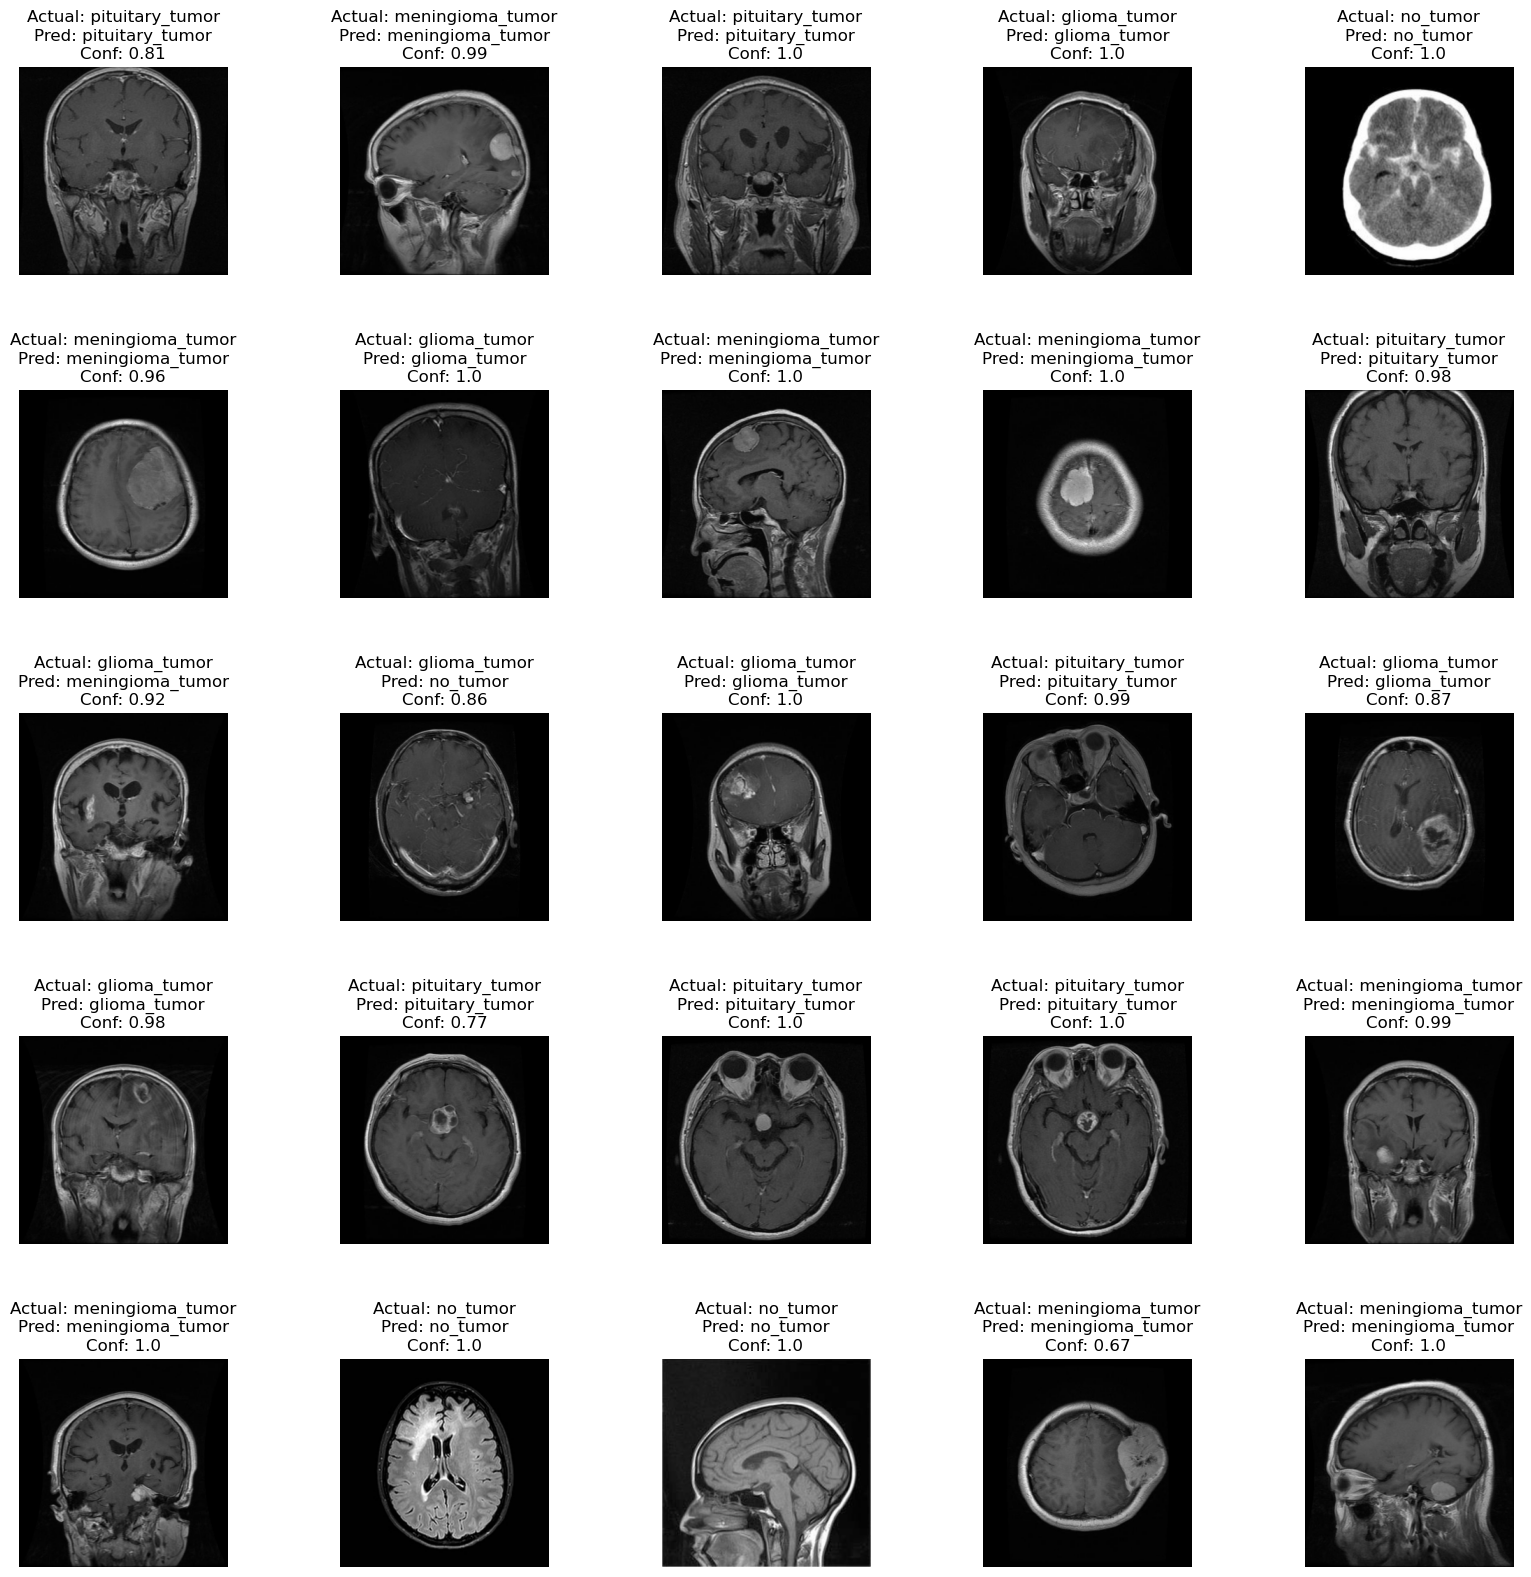

In [35]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)   

### II. Two hidden layers

In [44]:
basemodel = Xception(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (299, 299, 3)))


for layer in basemodel.layers[:-20]:
    layer.trainable = False

In [45]:
headmodel = basemodel.output
headmodel = MaxPooling2D()(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(2048, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2048, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model_1 = Model(inputs = basemodel.input, outputs = headmodel)

In [46]:
model_1.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [47]:
history = model_1.fit(X_train, y_train,
     epochs = 50, 
     validation_data = (X_test, y_test), 
     callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 1.4145 - accuracy: 0.2930
Epoch 1: val_loss did not improve from 0.31773
82/82 [==============================] - 13s 139ms/step - loss: 1.4145 - accuracy: 0.2930 - val_loss: 7.3161 - val_accuracy: 0.1485
Epoch 2/50
82/82 [==============================] - ETA: 0s - loss: 1.2793 - accuracy: 0.3543
Epoch 2: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 132ms/step - loss: 1.2793 - accuracy: 0.3543 - val_loss: 1.3085 - val_accuracy: 0.4074
Epoch 3/50
82/82 [==============================] - ETA: 0s - loss: 1.2066 - accuracy: 0.4209
Epoch 3: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 132ms/step - loss: 1.2066 - accuracy: 0.4209 - val_loss: 1.0769 - val_accuracy: 0.5207
Epoch 4/50
82/82 [==============================] - ETA: 0s - loss: 1.0484 - accuracy: 0.5515
Epoch 4: val_loss did not improve from 0.31773
82/82 [==============================] -

Epoch 31/50
82/82 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9778
Epoch 31: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 133ms/step - loss: 0.0979 - accuracy: 0.9778 - val_loss: 0.7951 - val_accuracy: 0.8423
Epoch 32/50
82/82 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9766
Epoch 32: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 132ms/step - loss: 0.0731 - accuracy: 0.9766 - val_loss: 1.1668 - val_accuracy: 0.8729
Epoch 33/50
82/82 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9809
Epoch 33: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 133ms/step - loss: 0.0790 - accuracy: 0.9809 - val_loss: 2.7807 - val_accuracy: 0.7534
Epoch 33: early stopping


C:\Users\User\AppData\Local\Temp\ipykernel_9892\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



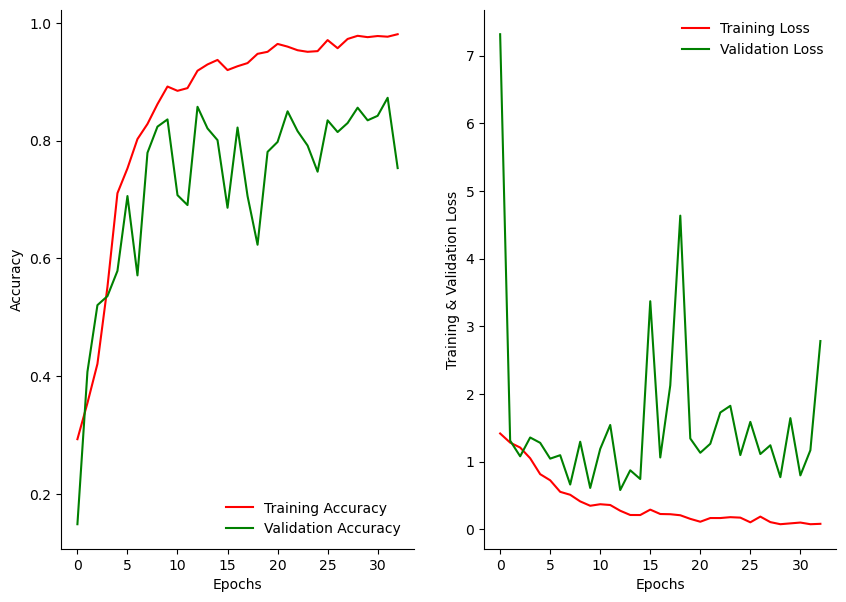

In [48]:
plot_history_acc_loss(history)

In [49]:
evaluate = model_1.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 2s 78ms/step - loss: 2.7807 - accuracy: 0.7534
Testing accuracy : 0.7534456253051758
Testing loss: 2.780667781829834


In [50]:
test_predictions = model_1.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 90ms/step
              precision    recall  f1-score   support

           0       0.95      0.35      0.51       181
           1       0.58      0.97      0.73       200
           2       0.90      0.87      0.89        95
           3       0.93      0.86      0.89       177

    accuracy                           0.75       653
   macro avg       0.84      0.76      0.76       653
weighted avg       0.83      0.75      0.74       653



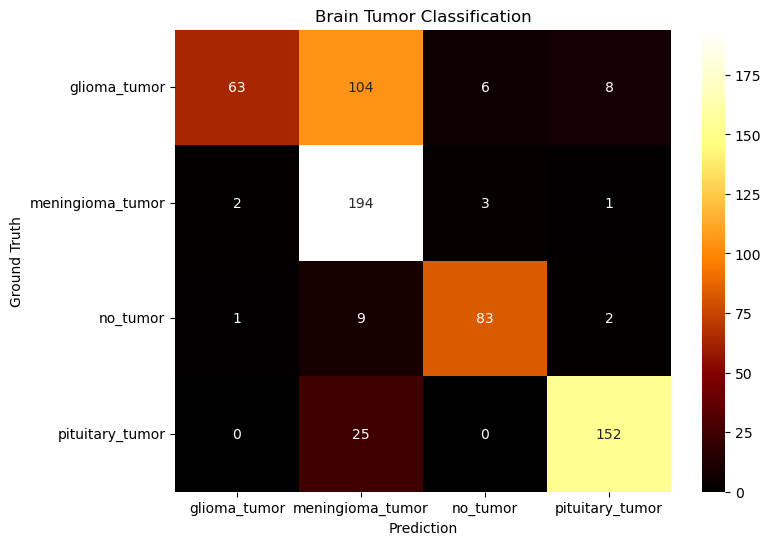

In [51]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cnf, cmap='afmhot', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    With two hidden layers, the model shows poor results. 

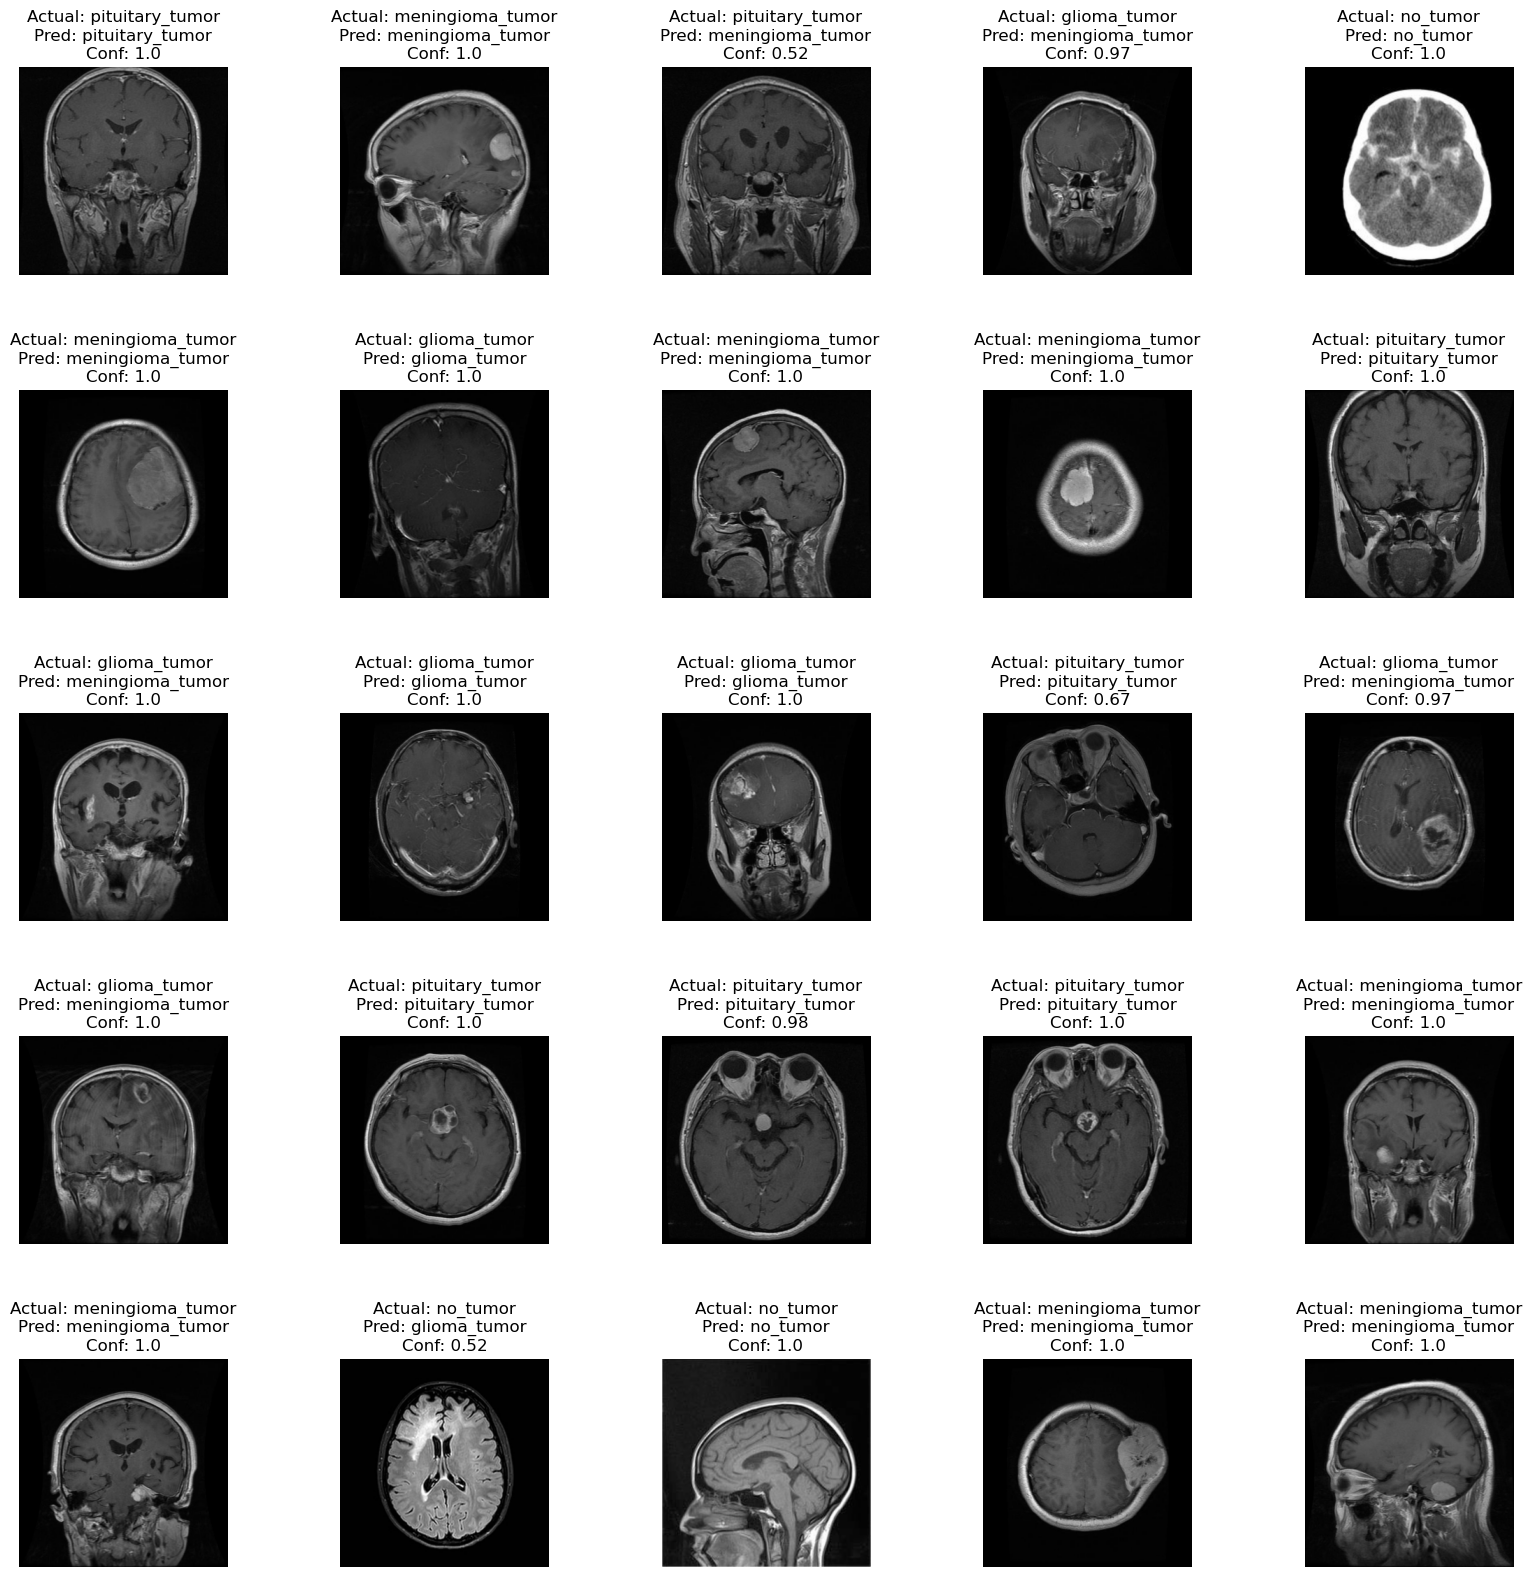

In [52]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  

### III. One convolutional layer and two dense layers

In [57]:
basemodel = Xception(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (299, 299, 3)))


for layer in basemodel.layers[:-20]:
    layer.trainable = False

In [53]:
headmodel = basemodel.output
headmodel = MaxPooling2D()(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Conv2D(738, 3, activation = 'relu')(headmodel)
headmodel = MaxPooling2D()(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(2048, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2048, activation = 'relu')(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


model_1 = Model(inputs = basemodel.input, outputs = headmodel)

In [54]:
model_1.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [55]:
history = model_1.fit(X_train, y_train,
     epochs = 50, 
     validation_data = (X_test, y_test), 
     callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.9111
Epoch 1: val_loss did not improve from 0.31773
82/82 [==============================] - 13s 136ms/step - loss: 0.3940 - accuracy: 0.9111 - val_loss: 3.0063 - val_accuracy: 0.6570
Epoch 2/50
82/82 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9640
Epoch 2: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 129ms/step - loss: 0.1604 - accuracy: 0.9640 - val_loss: 1.5077 - val_accuracy: 0.7626
Epoch 3/50
82/82 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9732
Epoch 3: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 129ms/step - loss: 0.1459 - accuracy: 0.9732 - val_loss: 0.7988 - val_accuracy: 0.7933
Epoch 4/50
82/82 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9655
Epoch 4: val_loss did not improve from 0.31773
82/82 [==============================] -

Epoch 31/50
82/82 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9981
Epoch 31: val_loss did not improve from 0.31773
82/82 [==============================] - 11s 130ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 1.8423 - val_accuracy: 0.8989
Epoch 31: early stopping


C:\Users\User\AppData\Local\Temp\ipykernel_9892\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



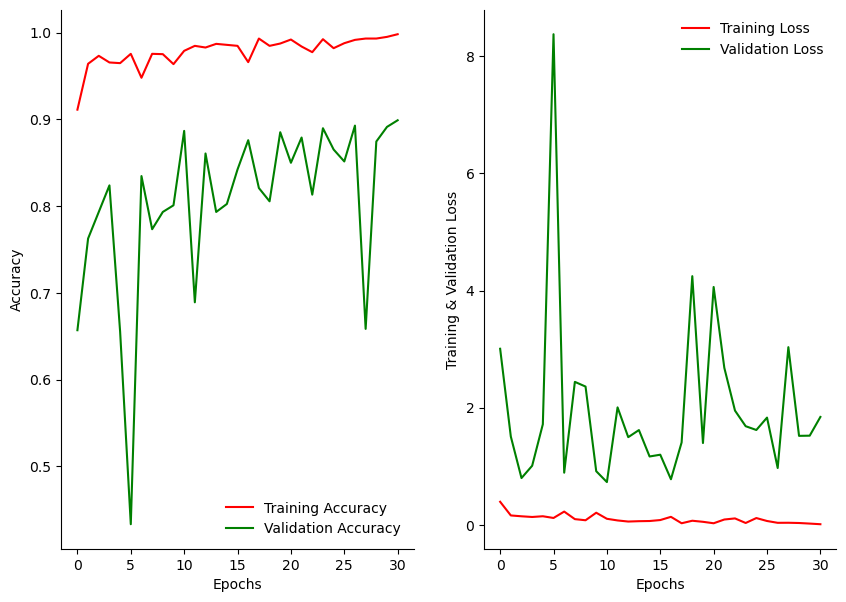

In [56]:
plot_history_acc_loss(history)

In [57]:
evaluate = model_1.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 2s 79ms/step - loss: 1.8423 - accuracy: 0.8989
Testing accuracy : 0.8989280462265015
Testing loss: 1.8422802686691284


In [58]:
test_predictions = model_1.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 92ms/step
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       181
           1       0.82      0.92      0.87       200
           2       0.92      0.83      0.87        95
           3       0.98      0.95      0.97       177

    accuracy                           0.90       653
   macro avg       0.91      0.89      0.90       653
weighted avg       0.90      0.90      0.90       653



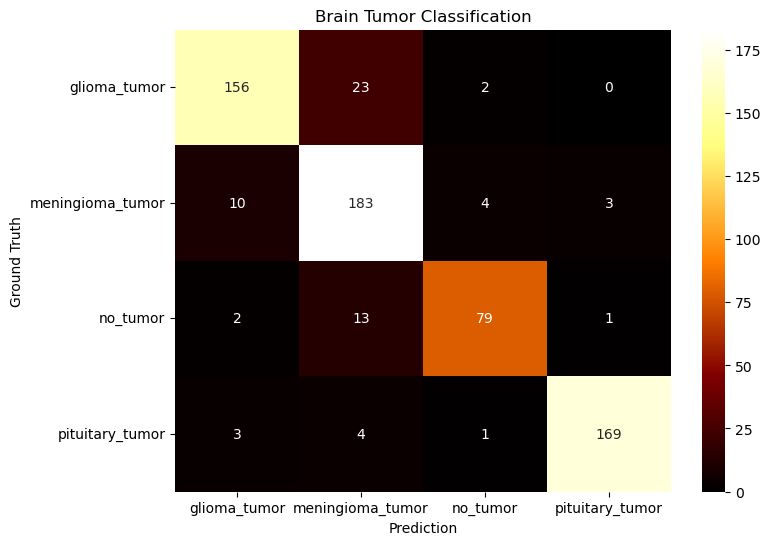

In [59]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cnf, cmap='afmhot', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    after adding layers, the model trains weakly overfit is preserved 

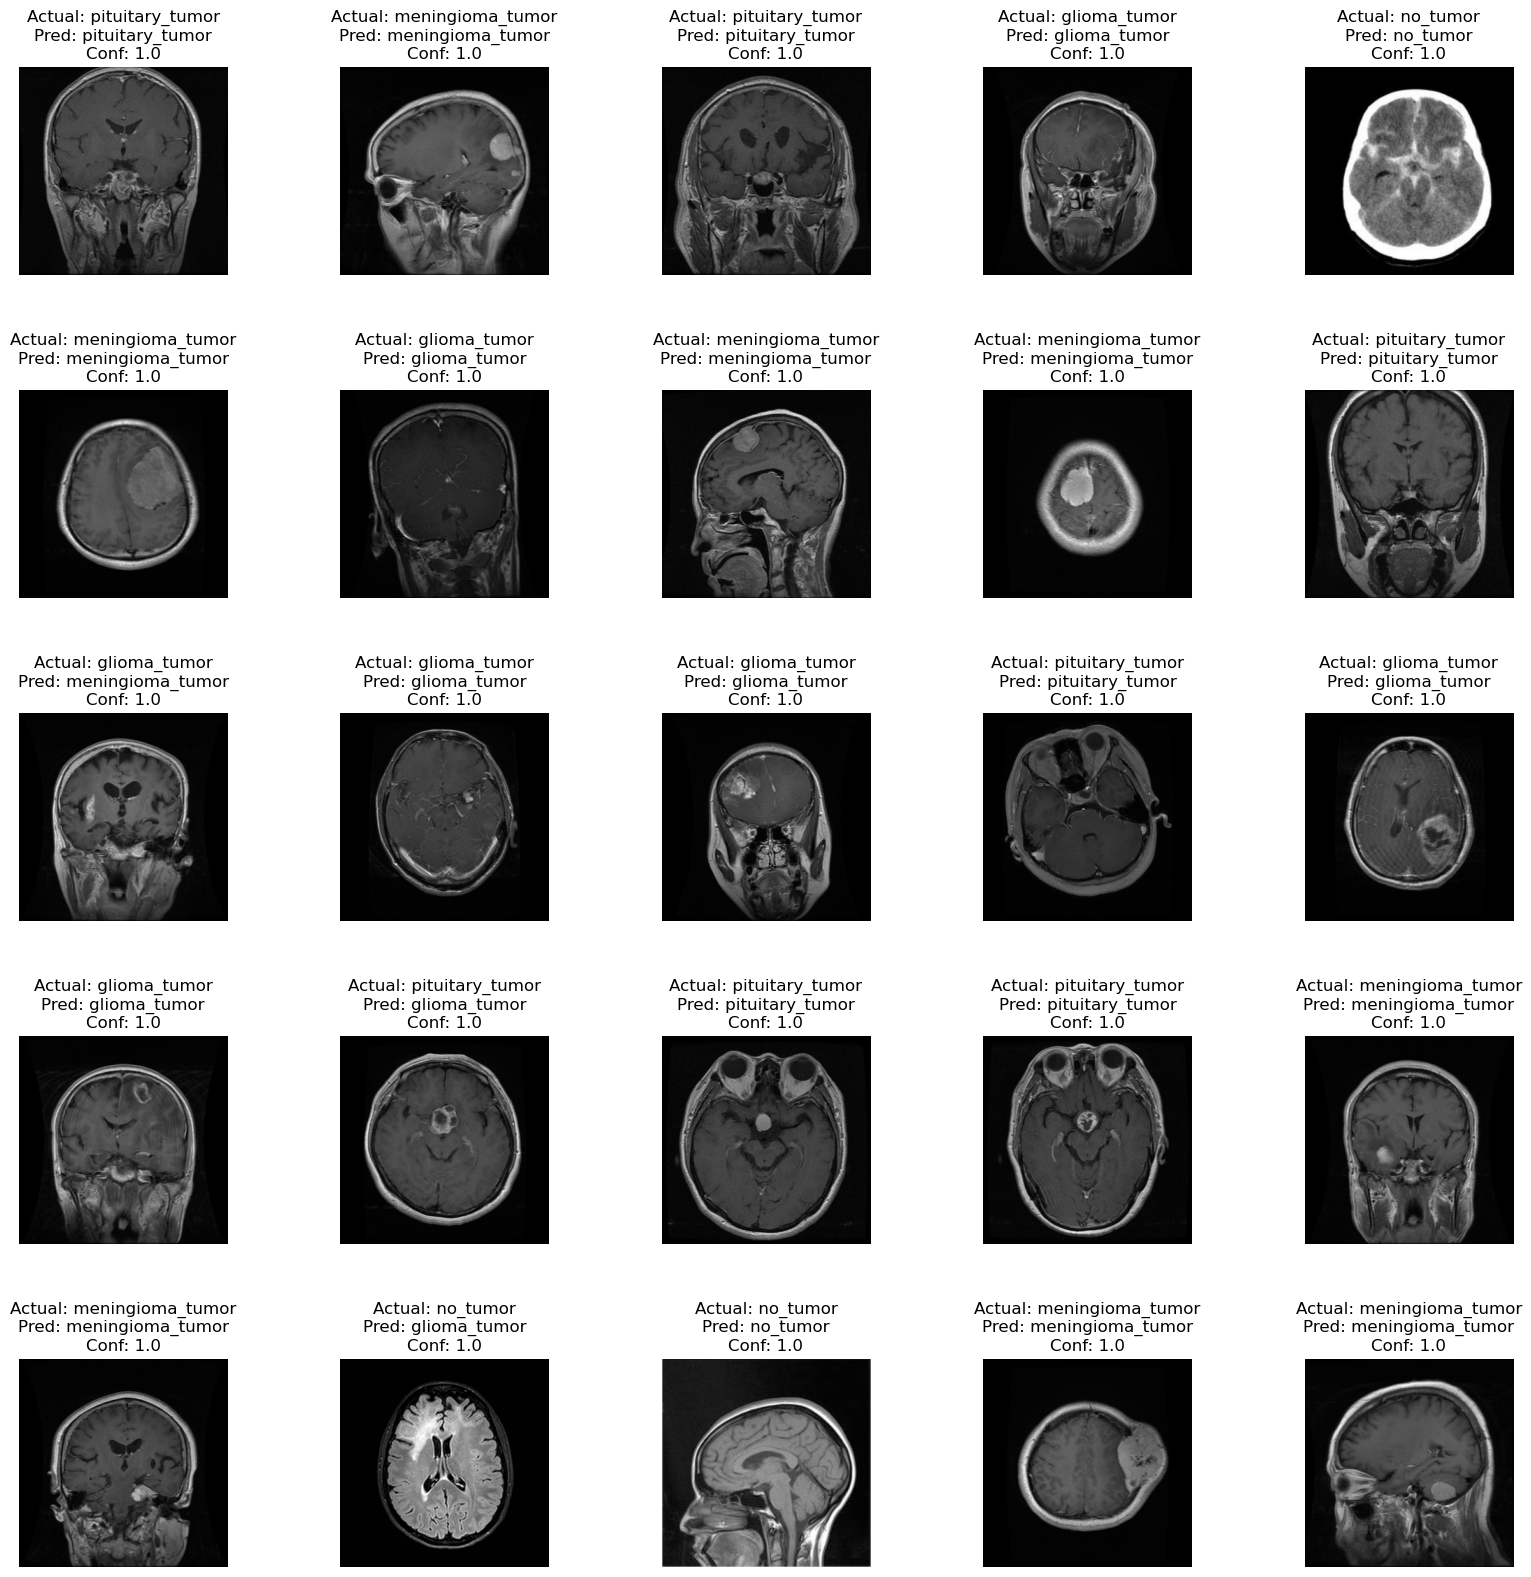

In [60]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  

### Conclusion

    If we compare all three attempts, the model with 1 convolutional layer and 2 hidden layers shows more or less stable results. 